In [1]:
import os

import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib widget

## Arbitrary sound

In [3]:
amplitude = 1
f0 = 440
sample_rate = 44100
damping = 2


def make_sound(amplitude, damping):
    times = np.linspace(0, 1, sample_rate)
    waveform = amplitude * np.exp(-damping * times) * np.cos(f0 * times)
    return waveform


waveform = make_sound(amplitude, damping)

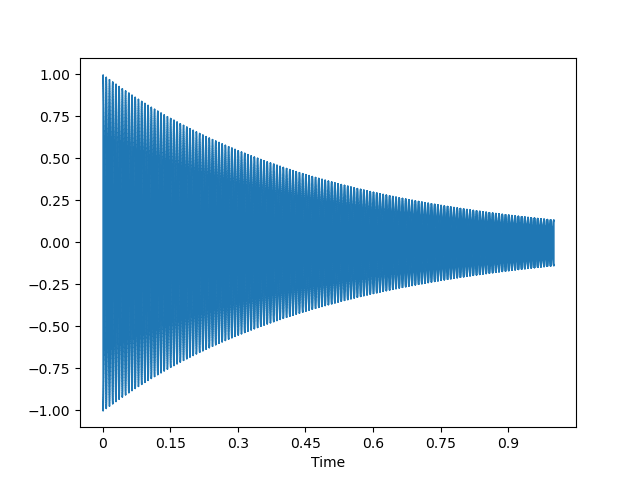

In [4]:
plt.figure()
# Display waveform
librosa.display.waveshow(waveform, sr=sample_rate)
plt.show()

## Sound/no sound criterion

In [5]:
N = len(waveform)

N2_3 = int(2 * N / 3)
criterion = np.mean(np.abs(waveform[N2_3:]))
print(criterion)


def are_there_oscillations(waveform, epsilon):
    N2_3 = int(2 * len(waveform) / 3)
    criterion = np.mean(np.abs(waveform[N2_3:]))
    return criterion > epsilon

0.12222087679658754


## Artificial map

Make dataset complete with labels

In [6]:
# Randomly sample data points (uniform distribution)
# Here we sample the amplitude and the damping factor

n_points = 100
data_coordinates = np.random.rand(n_points, 2)
data_coordinates[:, 1] *= 5
wave_dataset = np.zeros((n_points, sample_rate))
labels = np.zeros(n_points)

for i, x in enumerate(data_coordinates):
    ampl, damp = x
    waveform = make_sound(ampl, damp)
    wave_dataset[i] = waveform
    labels[i] = 1 if are_there_oscillations(waveform, epsilon=0.1) else -1

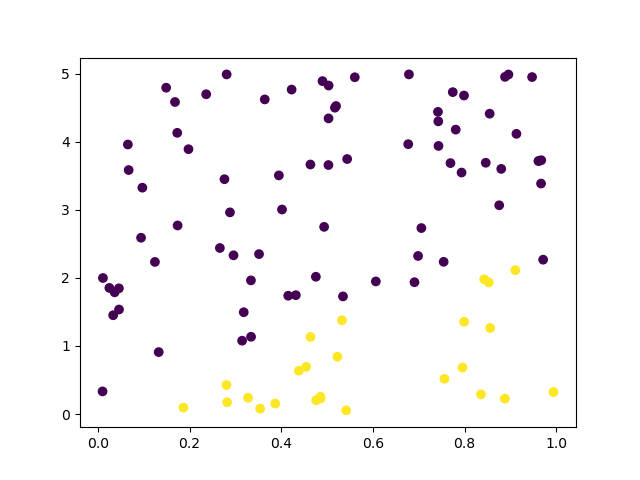

In [7]:
plt.figure()
plt.scatter(data_coordinates[:, 0], data_coordinates[:, 1], c=labels)
plt.show()

## Design of Experiments

In [27]:
from doepy import build

test = build.space_filling_lhs(
    {"gamma": [0, 3],
     "xi": [0, 1],
     "test": [0, 1]},
    num_samples=250
)

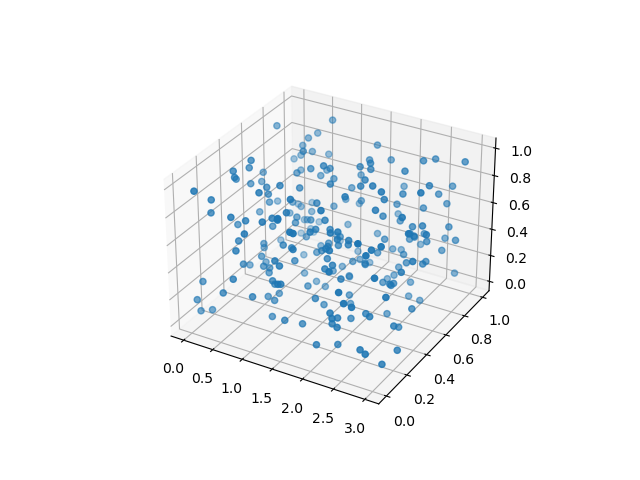

In [28]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(test["gamma"], test["xi"], test["test"])
plt.show()

## Support Vector Machine

In [28]:
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

In [29]:
model = SVC(kernel="rbf")
model.fit(data_coordinates, labels)

SVC()

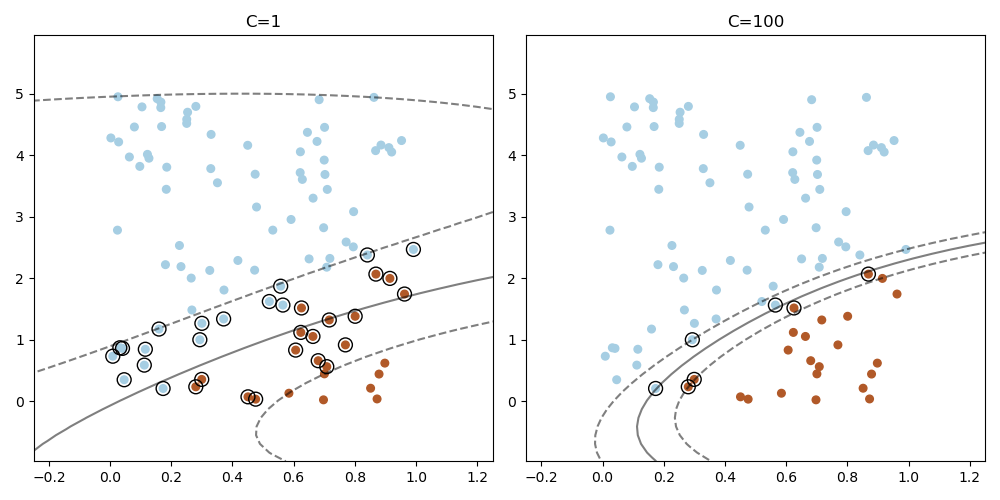

In [13]:
X, y = data_coordinates, labels

plt.figure(figsize=(10, 5))
for i, C in enumerate([1, 100]):
    # "hinge" is the standard SVM loss
    clf = SVC(C=C, random_state=42).fit(X, y)
    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X)
    # we can also calculate the decision function manually
    # decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
    # The support vectors are the samples that lie within the margin
    # boundaries, whose size is conventionally constrained to 1
    support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
    support_vectors = X[support_vector_indices]

    plt.subplot(1, 2, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        ax=ax,
        grid_resolution=50,
        plot_method="contour",
        colors="k",
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", "-", "--"],
    )
    plt.scatter(
        support_vectors[:, 0],
        support_vectors[:, 1],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="k",
    )
    plt.title("C=" + str(C))
    plt.xlim([-0.25, 1.25])
    # plt.ylim([-0.25, 10])
plt.tight_layout()
plt.show()

## Probability estimates

Probability of belonging to the positive class ie presence of sound

In [14]:
n_monte_carlo = 10000
points = np.random.rand(n_monte_carlo, 2)

indicator_function = clf.decision_function(points)
indicator_function[indicator_function < 0] = 0
indicator_function[indicator_function > 0] = 1
probability = np.sum(indicator_function)
probability /= n_monte_carlo

In [15]:
print(probability)

0.7491


## Adaptive sampling

Refinement of the SVM boundary

Idea : add samples by solving the following optimization problem

$$
\begin{align}
    \max_\mathbf{x} &||\mathbf{x} - \mathbf{x}_{nearest}|| \\
    \text{s.t. } &s(\mathbf{x}) = 0 \\
    &\mathbf{x_{min}} \leq \mathbf{x} \leq \mathbf{x}_{max}
\end{align}
$$

In [16]:
# TODO

## Test avec un premier modèle physique
Modèle de Maganza

In [87]:
### Définition des paramètres
import warnings

W = 2e-2  # Largeur de la anche de clarinette
H = 6.5e-2  # Longueur de la anche de clarinette
gamma_air = 1.4  # Indice adiabatique
rho = 1.292  # Masse vol air
c = 343  # Vitesse son
rc = 3e-2  # rayon de la clarinette
Lc = 60e-2  # longueur clarinette
Sc = np.pi * rc**2  # section clarinette
pM = 0.1  # Pression de plaquage statique
Y_m = 1 / 1233.36096998528  # Admittance premier mode
f = 220  # Fréquence premier mode

omega = 2 * np.pi * f
F1 = 2 * c / Lc

T = 2 * Lc / c
fe = 1 / T  # il faudra suréchantillonner ? temps très court....

Z0 = rho * c
eps = 0.05


def coeffs(gamma, xi):
    A = xi * (2 * gamma - 1) / 2 / np.sqrt(gamma)
    B = -xi * (3 * gamma - 1) / 8 / gamma ** (3 / 2)
    C = -xi * (gamma + 1) / 16 / gamma ** (5 / 2)
    return A, B, C


t_max = 1  # s
compute_time = np.arange(int(t_max / T)) * T

### Définition des fonctions


def F(p, A, B, C):
    "Relation de couplage : u = F(p)"
    return A * p + B * p**2 + C * p**3


def Fhat(x, A, B, C):
    theta = np.pi / 4
    rotation_matrix = np.array(
        [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
    )
    y = F(x, A, B, C)
    X = rotation_matrix @ np.array([[x], [y]])
    return X


def Fcal(x, A, B, C, eps, Z0):
    X = Fhat(x, A, B, C)
    return X[1] * (Z0 - eps) / (Z0 + eps)


def make_sound(gamma, xi):
    A, B, C = coeffs(gamma, xi)

    x = np.linspace(0, 1, 200)
    y = F(x, A, B, C)

    Fchapeau = np.zeros_like(x)
    Fcaligraphie = np.zeros_like(x)
    xprime = np.zeros_like(x)
    for i in range(len(x)):
        X = Fhat(x[i], A, B, C)
        Fchapeau[i] = X[1]
        xprime[i] = X[0]
        Fcaligraphie[i] = Fcal(x[i], A, B, C, eps, Z0)

    ### Initialisation
    N = len(compute_time)
    Xmoins = np.zeros(N)
    Xplus = np.zeros(N)
    p0 = pM * gamma

    Xmoins[0] = 0.5  # (p0 - Z0*F(p0,A,B,C))/np.sqrt(2)
    X = Fhat(Xmoins[0], A, B, C)
    Xplus[0] = X[1]

    for i in range(1, N):
        try:
            Xmoins[i] = -Fcal(Xmoins[i - 1], A, B, C, eps, Z0)
            X = Fhat(Xmoins[i], A, B, C)
            Xplus[i] = X[1]
        except RuntimeWarning:
            print(gamma, xi)

    p = (Xmoins + Xplus) / np.sqrt(2)
    f = (Xmoins - Xplus) / np.sqrt(2) / Z0
    
    return p

/home/leo/anaconda3/envs/atiam/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


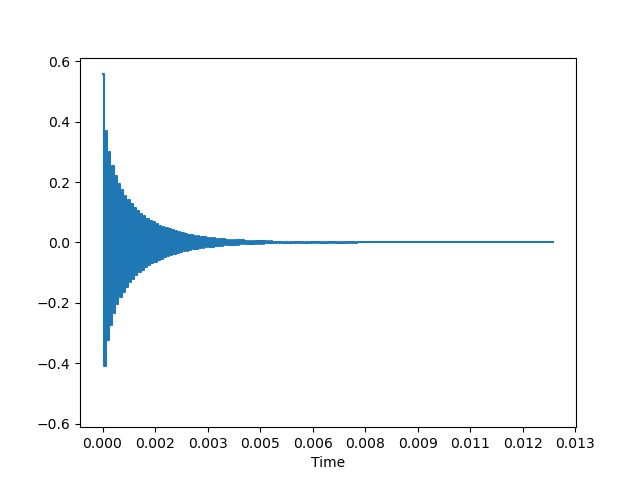

In [84]:
gamma = 0.6  # contrôle : rapport pm/pM
xi = W * H / Sc * np.sqrt(2 * gamma_air * rho / pM)
test = make_sound(gamma, xi)

plt.figure()
librosa.display.waveshow(test)
plt.show()

In [30]:
# Randomly sample data points (uniform distribution)
# Here we sample the gamma and xi parameters

n_points = 100
data_coordinates = np.random.rand(n_points, 2) * 0.85 + 0.15

# Gamma between 0 and 1

# Xi between 0 and 1
# data_coordinates[:, 1] = 2 * data_coordinates[:, 1] + 1

wave_dataset = np.zeros((n_points, len(make_sound(0.6, 2.76))))
labels = np.zeros(n_points)

# Catch warnings as errors
warnings.filterwarnings("error")

for i, x in enumerate(data_coordinates):
    ampl, damp = x
    waveform = make_sound(ampl, damp)
    wave_dataset[i] = waveform
    # labels[i] = 1 if are_there_oscillations(waveform, epsilon=1e-3) else -1
    N2_3 = int(2 * len(waveform) / 3)
    labels[i] = criterion = np.mean(np.abs(waveform[N2_3:]))
warnings.resetwarnings()

NameError: name 'warnings' is not defined

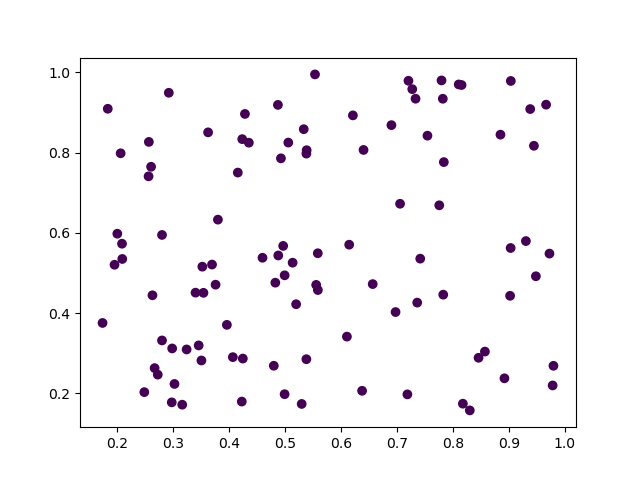

In [31]:
plt.figure()
plt.scatter(data_coordinates[:, 0], data_coordinates[:, 1], c=labels)
plt.show()